In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bunker Hill Insurance - credit - No- hit/Data/team2_driver.csv.gz')

In [ ]:
pol = pd.read_csv('/content/drive/MyDrive/BU Capstone Team2 Credit No_hit/Data/policy_level.csv')

In [ ]:
df.head()

,pol_id,year,STATE,ZIP5,ZIP4,no_hit
0,BHD00001001024,2016,MA,2740,1228.0,1
1,BHD00001001024,2017,MA,2740,1228.0,1
2,BHD00001001024,2018,MA,2740,1228.0,1
3,BHD00001001024,2019,MA,2740,1228.0,1
4,BHD00001001024,2020,MA,2740,1228.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400719 entries, 0 to 400718
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pol_id  400719 non-null  object 
 1   year    400719 non-null  int64  
 2   STATE   400719 non-null  object 
 3   ZIP5    400719 non-null  int64  
 4   ZIP4    395180 non-null  float64
 5   no_hit  400719 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 18.3+ MB


##EDA

> ### By policy id level
* take the first year record for each policy id (policy first existing year)

In [ ]:
# unique pol_id
df['pol_id'].nunique()

176704

In [ ]:
# only take the first existing year
grouped = df.groupby(['pol_id'])
gby = grouped.agg(lambda x: x.iloc[0])

In [ ]:
# result: each id only exist one time (first entered year)
gby.head()

,year,STATE,ZIP5,ZIP4,no_hit
pol_id,,,,,
BHD00001001024,2016,MA,2740,1228.0,1
BHD00001001030,2016,MA,2740,4523.0,1
BHD00001001034,2015,MA,2745,5672.0,0
BHD00001001037,2016,MA,1566,1335.0,0
BHD00001001041,2016,MA,2745,5260.0,0


In [ ]:
#Count consistent IDs
a = df.groupby(['pol_id'])['no_hit'].mean()
sum(a == 1) + sum(a == 0)

162534

In [ ]:
gby = gby.reset_index()
con = gby[gby['pol_id'].isin(np.array(a[(a==1) | (a==0)].index))]

In [ ]:
con.shape

(162534, 6)

In [ ]:
# not consis
nc = pd.read_csv('Book1 1.csv')
nc.head()

,pol_id,final
0,BHD00001002410,1
1,BHD00001002560,0
2,BHD00001002668,0
3,BHD00001002885,0
4,BHD00001002939,0


In [ ]:
#Count non-consistent IDs
b = df.groupby(['pol_id'])['no_hit'].mean()
len(b) - sum(b == 1) - sum(b == 0)

14170

In [ ]:
nonc = gby[gby['pol_id'].isin(np.array(b[(b != 0) & (b != 1)].index))]
nonc.head()

,pol_id,year,STATE,ZIP5,ZIP4,no_hit
220,BHD00001002410,2016,MA,2301,1464.0,0
272,BHD00001002560,2016,MA,1028,2318.0,0
317,BHD00001002668,2013,NH,1913,3319.0,1
408,BHD00001002885,2014,CT,1604,2355.0,0
442,BHD00001002939,2016,MA,2453,3446.0,1


In [ ]:
nonc = nonc.drop('no_hit', axis=1)
non = nonc.merge(nc, how='inner', on='pol_id').rename({'final':'no_hit'}, axis=1)
non.head()

,pol_id,year,STATE,ZIP5,ZIP4,no_hit
0,BHD00001002410,2016,MA,2301,1464.0,1
1,BHD00001002560,2016,MA,1028,2318.0,0
2,BHD00001002668,2013,NH,1913,3319.0,0
3,BHD00001002885,2014,CT,1604,2355.0,0
4,BHD00001002939,2016,MA,2453,3446.0,0


In [ ]:
# final policy level
pol = pd.concat([con, non])

In [ ]:
pol.head()

,pol_id,year,STATE,ZIP5,ZIP4,no_hit
0,BHD00001001024,2016,MA,2740,1228.0,1
1,BHD00001001030,2016,MA,2740,4523.0,1
2,BHD00001001034,2015,MA,2745,5672.0,0
3,BHD00001001037,2016,MA,1566,1335.0,0
4,BHD00001001041,2016,MA,2745,5260.0,0


In [ ]:
pol.shape

(176704, 6)

In [ ]:
pol.to_csv('policy_level.csv')

In [ ]:
# new existing id in each state
group_state = pol.reset_index().groupby('STATE').agg({'pol_id': 'nunique'})
per = group_state.apply(lambda x: x / float(x.sum())).round(2)
new = pd.concat([group_state.rename(columns = {'pol_id':'policy count'}), per.rename(columns = {'pol_id':'% of total policies'})], axis=1).sort_values(by='% of total policies',ascending=False)
new['appear_year'] = [2015, 2015, 2017, 2011, 2011, 2018]
new

,policy count,% of total policies,appear_year
STATE,,,
MA,67291,0.38,2015
NJ,47544,0.27,2015
PA,21576,0.12,2017
CT,19522,0.11,2011
NH,13673,0.08,2011
NY,7098,0.04,2018


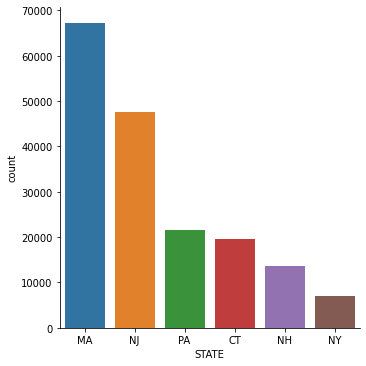

In [ ]:
# MA has the most policies, NY and PA are new states start from 2017-2018
sns.catplot(kind='count', x='STATE', data=gby, order=gby['STATE'].value_counts(ascending=False).index)

In [ ]:
# no-hit in these policies
nh_state = pol.groupby(['STATE'])[['no_hit']].sum()
nh_sc = pol.groupby(['STATE'])[['no_hit']].count()
hit = nh_sc - nh_state
pec_nh = (nh_state / nh_sc).round(3)
nh_sdf = pd.concat([nh_state.rename(columns = {'no_hit':'no_hit count'}), hit.rename(columns={'no_hit':'hit count'}), nh_sc.rename(columns = {'no_hit':'total policies'}), pec_nh.rename(columns = {'no_hit':'% of no_hit'})], axis=1).sort_values('% of no_hit', ascending=False)
nh_sdf

,no_hit count,hit count,total policies,% of no_hit
STATE,,,,
NY,1329,5769,7098,0.187
PA,3595,17981,21576,0.167
CT,1907,17615,19522,0.098
NH,1344,12329,13673,0.098
NJ,3739,43805,47544,0.079
MA,3979,63312,67291,0.059


In [ ]:
df = pd.DataFrame({'no_hit count': nh_sdf['no_hit count'],
                   'hit count': nh_sdf['hit count']}, index = nh_sdf.index)

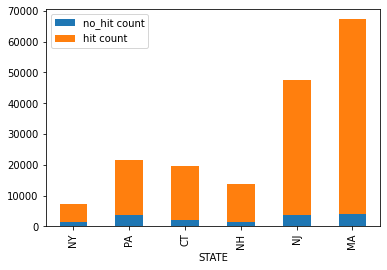

In [ ]:
df.plot.bar(stacked = True)

In [ ]:
# new policies entered in each year
group_year = pol.reset_index().groupby('year').agg({'pol_id': 'nunique'})
per_y = group_year.apply(lambda x: x / float(x.sum())).round(2)
pd.concat([group_year.rename(columns = {'pol_id':'policy count'}), per_y.rename(columns = {'pol_id':'% of total policies'})], axis=1)

,policy count,% of total policies
year,,
2011,3395,0.02
2012,767,0.00
2013,2409,0.01
2014,3045,0.02
2015,8441,0.05
2016,38605,0.22
2017,13133,0.07
2018,34965,0.20
2019,45210,0.26


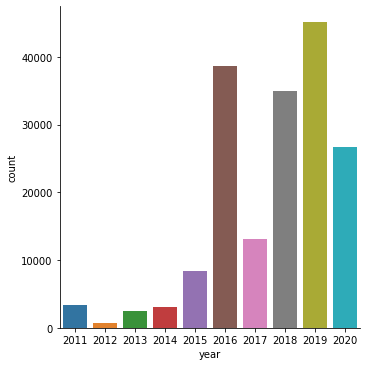

In [ ]:
sns.catplot(kind='count', x='year', data=pol)

In [ ]:
r = pol.reset_index().groupby(['year','STATE'])
t = r.agg({'pol_id':'nunique'})
t

pol_id
year STATE        
2011 CT        998
     NH       2397
2012 CT        476
     NH        291
2013 CT       1697
     NH        712
2014 CT       1765
     NH       1280
2015 CT       1211
     MA       4790
     NH       1605
     NJ        835
2016 CT       3341
     MA      29501
     NH       2077
     NJ       3686
2017 CT       2064
     MA       6419
     NH       1154
     NJ       3341
     PA        155
2018 CT       1727
     MA       8430
     NH       1371
     NJ      18200
     NY          6
     PA       5231
2019 CT       2977
     MA      11030
     NH       2011
     NJ      15790
     NY       1332
     PA      12070
2020 CT       3266
     MA       7121
     NH        775
     NJ       5692
     NY       5760
     PA       4120

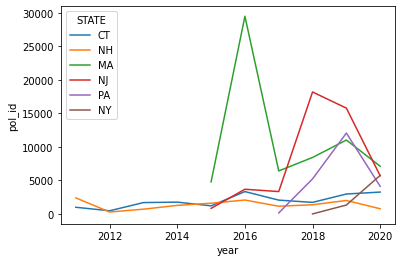

In [ ]:
sns.lineplot(x='year', y='pol_id',data=t, hue='STATE')

In [ ]:
# 每年新加入的policy，no-hit占那一年总加入人数的比例
nh_first = pol.groupby(['year'])[['no_hit']].sum()
nh_count = pol.groupby(['year'])[['no_hit']].count()
per_nh = (nh_first / nh_count).round(3)
nh_df = pd.concat([nh_first.rename(columns = {'no_hit':'no_hit count'}), nh_count.rename(columns = {'no_hit':'total new policies'}), per_nh.rename(columns = {'no_hit':'% of no_hit'})], axis=1)
nh_df

,no_hit count,total new policies,% of no_hit
year,,,
2011,173,3395,0.051
2012,28,767,0.037
2013,82,2409,0.034
2014,112,3045,0.037
2015,439,8441,0.052
2016,1502,38605,0.039
2017,554,13133,0.042
2018,1635,34965,0.047
2019,4385,45210,0.097


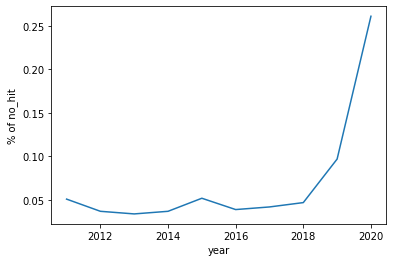

In [ ]:
sns.lineplot(x=nh_df.index, y='% of no_hit', data=nh_df)

In [ ]:
# 每年的新增nohit 在各州中的分布情况
u = pol.groupby(['year','STATE'])
o = r.agg({'no_hit':['sum','mean']})
o.columns = o.columns.droplevel(0)
o

sum      mean
year STATE                
2011 CT       20  0.020040
     NH      153  0.063830
2012 CT       16  0.033613
     NH       12  0.041237
2013 CT       54  0.031821
     NH       28  0.039326
2014 CT       50  0.028329
     NH       62  0.048438
2015 CT       48  0.039637
     MA      226  0.047182
     NH      106  0.066044
     NJ       59  0.070659
2016 CT       91  0.027237
     MA     1016  0.034440
     NH      227  0.109292
     NJ      168  0.045578
2017 CT       75  0.036337
     MA      211  0.032871
     NH       83  0.071924
     NJ      180  0.053876
     PA        5  0.032258
2018 CT       73  0.042270
     MA      243  0.028826
     NH      129  0.094092
     NJ      643  0.035330
     NY        1  0.166667
     PA      546  0.104378
2019 CT      351  0.117904
     MA      721  0.065367
     NH      278  0.138240
     NJ     1254  0.079417
     NY      192  0.144144
     PA     1589  0.131649
2020 CT     1129  0.345683
     MA     1562  0.219351
     NH      266  0.343226
     NJ     1435  0.252108
     NY     1136  0.197222
     PA     1455  0.353155

Text(0, 0.5, '% no-hit')

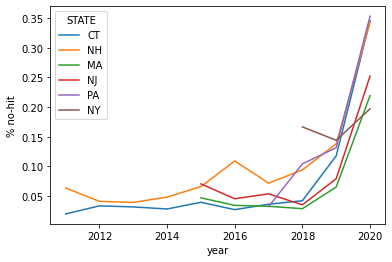

In [ ]:
sns.lineplot(x='year', y='mean',data=o, hue='STATE')
plt.ylabel('% no-hit')

> ### By policy id + years
* each policy id has a few records throughout several years

In [ ]:
# unique combinations
df.groupby(['pol_id','year']).nunique()

STATE  ZIP5  ZIP4  no_hit
pol_id         year                           
BHD00001001024 2016      1     1     1       1
               2017      1     1     1       1
               2018      1     1     1       1
               2019      1     1     1       1
               2020      1     1     1       1
...                    ...   ...   ...     ...
PNH00002031681 2020      1     1     1       1
PNH00002031723 2019      1     1     1       1
PNH00002031929 2018      1     1     1       1
               2019      1     1     1       1
PNH00002032007 2019      1     1     1       1

[400719 rows x 4 columns]

In [ ]:
# 每年都多少个policy（一个policy可以出现在很多年）
grouped_df1 = df.groupby('year').agg({'pol_id': 'nunique'})
grouped_df1

,pol_id
year,
2011,3395
2012,4084
2013,6421
2014,9307
2015,17002
2016,48540
2017,54852
2018,82698
2019,118134


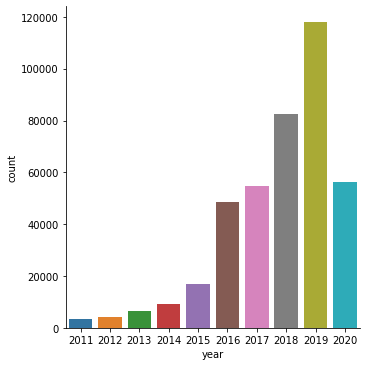

In [ ]:
sns.catplot(kind='count', x='year', data=df)

In [ ]:
# combine table
pd.concat([group_year.rename(columns = {'pol_id':'new policies'}), grouped_df1.rename(columns={'pol_id':'total policies'})], axis=1)

,new policies,total policies
year,,
2011,3395,3395
2012,767,4084
2013,2409,6421
2014,3045,9307
2015,8441,17002
2016,38605,48540
2017,13133,54852
2018,34965,82698
2019,45210,118134


In [ ]:
# 各州policy的分布情况
i = df.groupby(['year','STATE'])
p = i.agg({'pol_id':'nunique'})
p

pol_id
year STATE        
2011 CT        998
     NH       2397
2012 CT       1440
     NH       2644
2013 CT       3112
     NH       3309
2014 CT       4812
     NH       4495
2015 CT       5580
     MA       4791
     NH       5796
     NJ        835
2016 CT       7917
     MA      29885
     NH       7003
     NJ       3735
2017 CT       8692
     MA      32341
     NH       7261
     NJ       6403
     PA        155
2018 CT       8886
     MA      37039
     NH       7682
     NJ      23716
     NY          6
     PA       5369
2019 CT      10017
     MA      44246
     NH       8813
     NJ      36972
     NY       1338
     PA      16748
2020 CT       4606
     MA      23816
     NH       1765
     NJ      10625
     NY       5963
     PA       9511

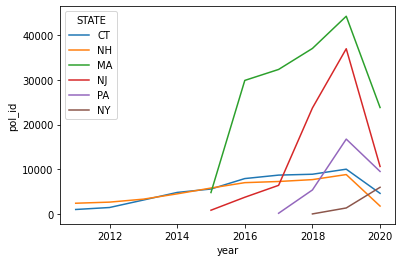

In [ ]:
sns.lineplot(x='year', y='pol_id',data=p, hue='STATE')

In [ ]:
# cumulative no_hit
nh_c = df.groupby(['year'])[['no_hit']].sum()
nht_count = df.groupby(['year'])[['no_hit']].count()
per_nht = (nh_c / nht_count).round(3)
nht_df = pd.concat([nh_c.rename(columns = {'no_hit':'no_hit count(cumulative)'}), nht_count.rename(columns = {'no_hit':'total policies'}), per_nht.rename(columns = {'no_hit':'% of no_hit(cumulative)'})], axis=1)

In [ ]:
nht_df

,no_hit count(cumulative),total policies,% of no_hit(cumulative)
year,,,
2011,273,3395,0.080
2012,327,4084,0.080
2013,587,6421,0.091
2014,697,9307,0.075
2015,1086,17002,0.064
2016,4086,48540,0.084
2017,4810,54852,0.088
2018,7461,82698,0.090
2019,9863,118134,0.083


In [ ]:
# combine table
combined = pd.concat([nh_df,nht_df], axis=1)
combined

,no_hit count,total new policies,% of no_hit,no_hit count(cumulative),total policies,% of no_hit(cumulative)
year,,,,,,
2011,173,3395,0.051,273,3395,0.080
2012,28,767,0.037,327,4084,0.080
2013,82,2409,0.034,587,6421,0.091
2014,112,3045,0.037,697,9307,0.075
2015,439,8441,0.052,1086,17002,0.064
2016,1502,38605,0.039,4086,48540,0.084
2017,554,13133,0.042,4810,54852,0.088
2018,1635,34965,0.047,7461,82698,0.090
2019,4385,45210,0.097,9863,118134,0.083


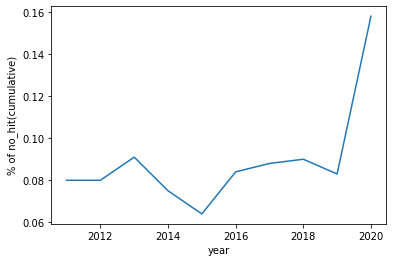

In [ ]:
sns.lineplot(x=combined.index, y='% of no_hit(cumulative)', data=combined)

In [ ]:
s = df.groupby(['year','STATE'])
d = s.agg({'no_hit':['sum', 'mean']})
d.columns = d.columns.droplevel(0)
d

sum      mean
year STATE                
2011 CT       45  0.045090
     NH      228  0.095119
2012 CT       87  0.060417
     NH      240  0.090772
2013 CT      291  0.093509
     NH      296  0.089453
2014 CT      338  0.070241
     NH      359  0.079867
2015 CT      282  0.050538
     MA      249  0.051972
     NH      487  0.084023
     NJ       68  0.081437
2016 CT      457  0.057724
     MA     2448  0.081914
     NH      718  0.102527
     NJ      463  0.123963
2017 CT      542  0.062356
     MA     2815  0.087041
     NH      733  0.100950
     NJ      687  0.107293
     PA       33  0.212903
2018 CT      557  0.062683
     MA     3356  0.090607
     NH      785  0.102187
     NJ     1287  0.054267
     NY        1  0.166667
     PA     1475  0.274725
2019 CT      696  0.069482
     MA     2728  0.061655
     NH      819  0.092931
     NJ     2422  0.065509
     NY      208  0.155456
     PA     2990  0.178529
2020 CT     1247  0.270734
     MA     2133  0.089562
     NH      406  0.230028
     NJ     1835  0.172706
     NY     1184  0.198558
     PA     2101  0.220902

Text(0, 0.5, '% of no-hit(cumulative)')

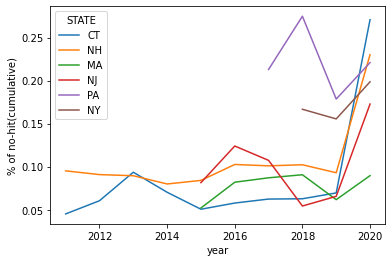

In [ ]:
sns.lineplot(x='year', y='mean',data=d, hue='STATE')
plt.ylabel('% of no-hit(cumulative)')

## Random stuff

In [ ]:
 df.groupby(['pol_id','STATE']).nunique()

,,year,ZIP5,ZIP4,no_hit
pol_id,STATE,,,,
BHD00001001024,MA,5,1,1,1
BHD00001001030,MA,5,1,1,1
BHD00001001034,MA,1,1,1,1
BHD00001001037,MA,5,1,1,1
BHD00001001041,MA,5,1,1,1
...,...,...,...,...,...
PNH00002031672,PA,1,1,1,1
PNH00002031681,PA,1,1,1,1
PNH00002031723,PA,1,1,1,1


In [ ]:
# 2019年hit/no-hit stats
nineteen = df[df['year']==2019]
grouped19 = nineteen.groupby('no_hit').agg({'pol_id': 'nunique'})
per19 = grouped19.apply(lambda x: x / len(gby)).round(2)
pd.concat([grouped19.rename(columns = {'pol_id':'pol_id num'}), per19.rename(columns = {'pol_id':'percentage'})], axis=1).sort_values(by='percentage', ascending=False)

,pol_id num,percentage
no_hit,,
0,108271,0.61
1,9863,0.06


In [ ]:
# 2018 + 2019 hit/no-hit stats
years = [2017, 2018, 2019]
comb = df[df.year.isin(years)]
grouped_c = comb.groupby('no_hit').agg({'pol_id': 'nunique'})
per_c = grouped_c.apply(lambda x: x / len(gby)).round(2)
pd.concat([grouped_c.rename(columns = {'pol_id':'pol_id num'}), per_c.rename(columns = {'pol_id':'percentage'})], axis=1).sort_values(by='percentage', ascending=False)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

,pol_id num,percentage
no_hit,,
0,124909,0.71
1,17948,0.10


In [ ]:
# summary by no-hit using pol_id and year, 全部hit/no-hit rate
tot = df.groupby(['no_hit'])[['pol_id']].count()
per_t = tot.apply(lambda x: x / len(df)).round(3)
pd.concat([tot.rename(columns = {'pol_id':'pol_id num'}), per_t.rename(columns = {'pol_id':'percentage'})], axis=1).sort_values(by='percentage', ascending=False)

,pol_id num,percentage
no_hit,,
0,362623,0.905
1,38096,0.095


In [ ]:
# no_hit summary by pol_id
df.groupby(['pol_id'])[['no_hit']].sum().head()

,no_hit
pol_id,
BHD00001001024,5
BHD00001001030,5
BHD00001001034,0
BHD00001001037,0
BHD00001001041,0


In [ ]:
# average no-hit ratio over 10 years
df.groupby(['year'])[['no_hit']].mean().mean()

no_hit    0.089447
dtype: float64

In [ ]:
# average no-hit ratio over states
df.groupby(['STATE'])[['no_hit']].mean().mean()

no_hit    0.12339
dtype: float64

In [ ]:
# Does the same ID keep a consistent no-hit situation over recording years?
q = df.groupby(['pol_id'])['no_hit'].sum()/df.groupby(['pol_id'])['year'].count()
q

pol_id
BHD00001001024    1.0
BHD00001001030    1.0
BHD00001001034    0.0
BHD00001001037    0.0
BHD00001001041    0.0
                 ... 
PNH00002031672    0.0
PNH00002031681    0.0
PNH00002031723    0.0
PNH00002031929    0.0
PNH00002032007    0.0
Length: 176704, dtype: float64

In [ ]:
#Count non-consistent IDs
a = df.groupby(['pol_id'])['no_hit'].mean()
len(a) - sum(a == 1) - sum(a == 0)

14170

In [ ]:
#filter our non-consistent rows
nonc = a[(a != 0) & (a != 1)]
nonc.index
df_nonc = df[df['pol_id'].isin(np.array(nonc.index))]
excel = df_nonc.pivot(index='pol_id', columns= 'year', values= 'no_hit')
excel

year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
pol_id,,,,,,,,,,
BHD00001002410,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN
BHD00001002560,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN
BHD00001002668,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
BHD00001002885,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN
BHD00001002939,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
PNH00002027385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN
PNH00002027689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
PNH00002028175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0


In [ ]:
excel.to_csv('excel.csv')

In [ ]:
#or by states
ma = df_nonc[df_nonc['STATE'] == 'MA']
nj = df_nonc[df_nonc['STATE'] == 'NJ']
pa = df_nonc[df_nonc['STATE'] == 'PA']
ct = df_nonc[df_nonc['STATE'] == 'CT']
nh = df_nonc[df_nonc['STATE'] == 'NH']
ny = df_nonc[df_nonc['STATE'] == 'NY']

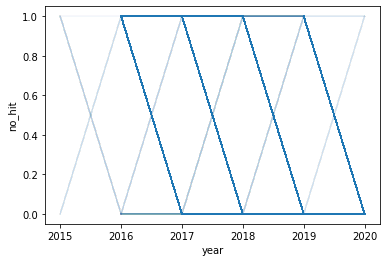

In [ ]:
# Change of hit/no-hit for ma
sns.lineplot(data= ma, x= 'year', y= 'no_hit',estimator = None, units= 'pol_id', alpha = 0.01)

In [ ]:
sns.lineplot(data= nj, x= 'year', y= 'no_hit',estimator = None, units= 'pol_id', alpha = 0.01)

In [ ]:
sns.lineplot(data= pa, x= 'year', y= 'no_hit',estimator = None, units= 'pol_id', alpha = 0.01)

In [ ]:
sns.lineplot(data= ct, x= 'year', y= 'no_hit',estimator = None, units= 'pol_id', alpha = 0.01)

In [ ]:
sns.lineplot(data= nh, x= 'year', y= 'no_hit',estimator = None, units= 'pol_id', alpha = 0.01)

In [ ]:
sns.lineplot(data= ny, x= 'year', y= 'no_hit',estimator = None, units= 'pol_id', alpha = 0.1)

In [ ]:
error.iloc[list(edf['nstate'] != 1)]

In [ ]:
edf[edf['nstate'] != 1]

In [ ]:
edf = pd.DataFrame(eindex,columns=['pol_id','nstate'])

In [ ]:
eindex = []
for i in list(range(176704)):
    eindex.append([error.index[i],pd.Series(error.iloc[i].values).nunique()])

In [ ]:
error = df.pivot(index='pol_id', columns= 'year',values='STATE')